In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
# default_exp eda

# IEEE-CIS Fraud Detection
https://www.kaggle.com/c/ieee-fraud-detection/

Imagine standing at the check-out counter at the grocery store with a long line behind you and the cashier not-so-quietly announces that your card has been declined. In this moment, you probably aren’t thinking about the data science that determined your fate.

Embarrassed, and certain you have the funds to cover everything needed for an epic nacho party for 50 of your closest friends, you try your card again. Same result. As you step aside and allow the cashier to tend to the next customer, you receive a text message from your bank. “Press 1 if you really tried to spend $500 on cheddar cheese.”

While perhaps cumbersome (and often embarrassing) in the moment, this fraud prevention system is actually saving consumers millions of dollars per year. Researchers from the IEEE Computational Intelligence Society (IEEE-CIS) want to improve this figure, while also improving the customer experience. With higher accuracy fraud detection, you can get on with your chips without the hassle.

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

In this competition, you’ll benchmark machine learning models on a challenging large-scale dataset. The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. You also have the opportunity to create new features to improve your results.

If successful, you’ll improve the efficacy of fraudulent transaction alerts for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. And of course, you will save party people just like you the hassle of false positives.

Acknowledgements:

Vesta Corporation provided the dataset for this competition. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995, Vesta pioneered the process of fully guaranteed card-not-present (CNP) payment transactions for the telecommunications industry. Since then, Vesta has firmly expanded data science and machine learning capabilities across the globe and solidified its position as the leader in guaranteed ecommerce payments. Today, Vesta guarantees more than $18B in transactions annually.

Header Photo by Tim Evans on Unsplash

## Evaluation
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.
Submission File

For each TransactionID in the test set, you must predict a probability for the isFraud variable. The file should contain a header and have the following format:

    TransactionID,isFraud
    3663549,0.5
    3663550,0.5
    3663551,0.5
    etc.

## Prizes

    1st Prize: $10,000
    2nd Prize: $7,000
    3rd Prize: $3,000

Winners will be required to submit a write-up for the IEEE CIS Conference, to which they are invited and highly encouraged to attend and present their work.


## Timeline
UPDATE: The below timeline has been updated according to this post. Please see that post and the competition rules for more details.

    September 24, 2019 - Entry deadline. You must accept the competition rules before this date in order to compete.

    September 24, 2019 - Team Merger deadline. This is the last day participants may join or merge teams.

    September 24, 2019 - External Data Disclosure deadline. This is the last day to disclose any used external data to the competition forums

    October 3, 2019 - Final submission deadline. After this date, we will not be taking any more submissions. Remember to select your two best submissions for final scoring.




## Data Description

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information.

### Categorical Features - Transaction

    ProductCD
    card1 - card6
    addr1, addr2
    P_emaildomain
    R_emaildomain
    M1 - M9

### Categorical Features - Identity

    DeviceType
    DeviceInfo
    id_12 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

You can read more about the data from this post by the competition host.
### Files

    train_{transaction, identity}.csv - the training set
    test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
    sample_submission.csv - a sample submission file in the correct format

# lib导入

In [12]:
# export
import os
from code.config import * 
from loguru import logger
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)  # 设置显示数据的最大列数，防止出现省略号…，导致数据显示不全
pd.set_option('expand_frame_repr', False)  # 当列太多时不自动换行

In [9]:
import sys
sys.path.append('..')
import seaborn as sns
sns.set(font='Arial Unicode MS')  # 解决Seaborn中文显示问题
from mylib.utils.pickle import PickleWrapper
from mylib.data.processing.eda import describe

In [4]:
args.DATA_DIR

'../../data/contest/ieee-fraud-detection/'

In [5]:
!ls ../../data/contest/ieee-fraud-detection/

sample_submission.csv test_transaction.csv  train_transaction.csv
test_identity.csv     train_identity.csv


# EDA

## Data Description (Details and Discussion)
https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203



    Transaction Table *

    TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
    TransactionAMT: transaction payment amount in USD
    ProductCD: product code, the product for each transaction
    card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
    addr: address
    dist: distance
    P_ and (R__) emaildomain: purchaser and recipient email domain
    C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
    D1-D15: timedelta, such as days between previous transaction, etc.
    M1-M9: match, such as names on card and address, etc.
    Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

    Categorical Features:
    ProductCD
    card1 - card6
    addr1, addr2
    Pemaildomain Remaildomain
    M1 - M9

    Identity Table *

    Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
    They're collected by Vesta’s fraud protection system and digital security partners.
    (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

    Categorical Features:
    DeviceType
    DeviceInfo
    id12 - id38

## train_transaction

In [63]:
test_transaction = pd.read_csv(os.path.join(args.DATA_DIR, 'test_transaction.csv')\
#                                 , converters={c: str for c in cols_str}
                               )

In [64]:
test_transaction.shape

(506691, 393)

In [7]:
cols_str = 'TransactionID ProductCD card1 card2 card3 card4 card5 card6 addr1 addr2 P_emaildomain R_emaildomain'.split()\
            + [f'M{i+1}' for i in range(9)]
train_transaction = pd.read_csv(os.path.join(args.DATA_DIR, 'train_transaction.csv')\
#                                 , converters={c: str for c in cols_str}
                               )

In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train_transaction.isFraud.value_counts()

0    569877
1     20663
Name: isFraud, dtype: int64

In [10]:
train_transaction_info = describe(train_transaction)

num of records: 590540, num of columns: 394


In [13]:
train_transaction_info

,Data Type,Unique Values,count Missing,% Missing,Mode,Count Mode,% Mode,mean,std,min,25%,50%,75%,max
TransactionID,int64,590540,0,0.00,2987000,1,0.000169337,3.28227e+06,170474,2.987e+06,3.13463e+06,3.28227e+06,3.4299e+06,3.57754e+06
isFraud,int64,2,0,0.00,0,569877,96.501,0.03499,0.183755,0,0,0,0,1
TransactionDT,int64,573349,0,0.00,9.47482e+06,8,0.00135469,7.37231e+06,4.61722e+06,86400,3.02706e+06,7.30653e+06,1.12466e+07,1.58111e+07
TransactionAmt,float64,20902,0,0.00,59,30582,5.17865,135.027,239.163,0.251,43.321,68.769,125,31937.4
ProductCD,object,5,0,0.00,W,439670,74.4522,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card1,int64,13553,0,0.00,7919,14932,2.52853,9898.73,4901.17,1000,6019,9678,14184,18396
card2,float64,500,8933,1.51,321,48935,8.28648,362.555,157.793,100,214,361,512,600
card3,float64,114,1565,0.27,150,521287,88.2729,153.195,11.3364,100,150,150,150,231
card4,object,4,1577,0.27,visa,384767,65.1551,NaN,NaN,NaN,NaN,NaN,NaN,NaN
card5,float64,119,4259,0.72,226,296546,50.2161,199.279,41.2445,100,166,226,226,237


## train_identity

In [14]:
cols_str = 'DeviceType DeviceInfo'.split()\
            + [f'id_{i}' for i in range(12, 39)]
train_identity = pd.read_csv(os.path.join(args.DATA_DIR, 'train_identity.csv')\
#                                 , converters={c: str for c in cols_str}
                               )

In [15]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [16]:
train_identity_info = describe(train_identity)

num of records: 144233, num of columns: 41


In [17]:
train_identity_info

,Data Type,Unique Values,count Missing,% Missing,Mode,Count Mode,% Mode,mean,std,min,25%,50%,75%,max
TransactionID,int64,144233,0,0.00,2987004,1,0.000693323,3.23633e+06,178850,2.987e+06,3.07714e+06,3.19882e+06,3.39292e+06,3.57753e+06
id_01,float64,77,0,0.00,-5,82170,56.9703,-10.1705,14.3479,-100,-10,-5,-5,0
id_02,float64,115655,3361,2.33,1102,11,0.00762655,174717,159652,1,67992,125800,228749,999595
id_03,float64,24,77909,54.02,0,63903,44.3054,0.0601894,0.598231,-13,0,0,0,10
id_04,float64,15,77909,54.02,0,65739,45.5783,-0.0589379,0.701015,-28,0,0,0,0
id_05,float64,93,7368,5.11,0,92743,64.3008,1.61558,5.24986,-72,0,0,1,52
id_06,float64,101,7368,5.11,0,91325,63.3177,-6.69871,16.4911,-100,-6,0,0,0
id_07,float64,84,139078,96.43,0,409,0.283569,13.2854,11.3842,-46,5,14,22,61
id_08,float64,94,139078,96.43,-100,500,0.346661,-38.6004,26.0849,-100,-48,-34,-23,0
id_09,float64,46,69307,48.05,0,70378,48.7947,0.0910231,0.983842,-36,0,0,0,25


# 1st Place Solution - Part 1
https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284

## Magic Feature
We are not predicting fraudulent __transactions__. According to the competition host Lynn here. Once a client (credit card) has fraud, their entire account is converted to isFraud=1. Therefore we are predicting fraudulent __clients (credit cards)__.

    The logic of our labeling is define reported chargeback on the card as fraud transaction (isFraud=1) and transactions posterior to it with either user account, email address or billing address directly linked to these attributes as fraud too. If none of above is reported and found beyond 120 days, then we define as legit transaction (isFraud=0).

您可能认为120天后，卡片变成isFraud = 0。 我们很少在训练数据中看到这一点。 （也许欺诈性信用卡会被终止而不是重新使用）。 下面的饼图显示了这一点。 训练数据集有73838个客户（信用卡），交易量为2个或更多。 其中，71575（96.9％）始终为isFraud = 0，2134（2.9％）始终为isFraud = 1。 只有129（0.2％）具有isFraud = 0和isFraud = 1的混合。

## Fraudulent Clients
以下是2134个示例中的一个示例，我可以向您展示isFraud = 1的客户端。 

这是client = 2988694标识客户端的关键是card1，addr1和D1这三列。 

D1列是“自客户（信用卡）开始以来的天数”。

因此，如果我们创建D1n = TransactionDay减去D1，则得出卡开始的日期（其中TransactionDay = TransactionDT /（24 * 60 * 60））。 

在下面的示例中，此信用卡的开始日期为-81（大约为2017年9月10日，因为据认为数据集将于2017年12月1日开始）。 

我们还看到D3n = TransactionDay减去D3是指向每个客户的最后一笔交易的日期的指针。 （还有更多列可帮助我们识别客户）。

## Preventing Overfitting
为了避免过度拟合训练和过度拟合公共测试数据集，我们一定不能直接使用客户端UID，也不能使用数据集中的数十列来帮助识别客户端的列，例如某些D，V和ID列。 （您知道哪些列在此处说明的训练/测试对抗性验证期间通过回顾LGBM功能重要性来标识客户）。

我们无法将UID添加为新列，因为私人测试数据集中68.2％的客户端不在训练数据集中。 相反，我们必须创建聚合组特征。 例如，我们可以获取所有C，M列，并执行new_features = df.groupby（'uid'）[CM_columns] .agg（['mean']）。 然后我们删除列uid。 现在，我们的模型具有对客户进行分类的能力，这是以前从未见过的。

## Model Details

There is so much more to say. Namely, I know you would like to know the specifics of our EDA, our models, validation methodology, and stacking/ensembling methodology. Konstantin has provided a brief summary here. I will begin working on "1st Place Solution - Part 2" that describes the technical aspects in more detail. Also we will begin sharing our code as we clean it up.

I look forward to reading everyone's solutions. Please share. 

# 1st Place Solution - Part 2
https://www.kaggle.com/c/ieee-fraud-detection/discussion/111308

In "1st Place Solution - Part 1" posted here, we discussed the benefits of classifying clients (credit cards) instead of transactions in Kaggle's Fraud competition. Here we will discuss the technical details. 

## Final Model

Our final model was a combination of 3 high scoring single models. 
* CatBoost (Public/Private LB of 0.9639/0.9408), 
* LGBM (0.9617/0.9384), and 
* XGB (0.9602/0.9324). 

These models were diversified because Konstantin built the CAT and LGB while I built the XGB and NN. And we engineered features independently. (In the end we didn't use the NN which had LB 0.9432). XGB notebook posted here.

One final submission was a stack where LGBM was trained on top of the predictions of CAT and XGB and the other final submission was an ensemble with equal weights. 

Both submissions were __post processed__ by taking all predictions from a single client (credit card) and replacing them with that client's average prediction. This PP increased LB by 0.001.

## How to Find UIDs

We found UIDs in two different ways. (Specific details here).

    Wrote a script that finds UIDs here
    Train our models to find UIDs here and here

If you remember, Konstantin's original public FE kernel here without UIDs achieves local validation AUC = 0.9245 and public LB 0.9485. His new FE kernel here achieves local validation AUC = 0.9377 and public LB 0.9617 by finding and using UIDs. Soon I will post my XGB kernel which finds UIDs with even less human assistance and proves to beat all other methods of finding UIDs. (XGB posted here). The purpose of producing UIDs by a script was for EDA, special validation tests, and post process. We did not add the script's UIDs to our models. Machine learning did better finding them on its own.
EDA

EDA was daunting in this competition. There were so many columns to analyze and their meanings were obscured. For the first 150 columns, we used Alijs's great EDA here. For the remaining 300 columns, we used my V and ID EDA here. We reduced the number of V columns with 3 tricks. First groups of V columns were found that shared similar NAN structure, next we used 1 of 3 methods:

    We applied PCA on each group individually
    We selected a maximum sized subset of uncorrelated columns from each group
    We replaced the entire group with all columns averaged.

Afterward, these reduced groups were further evaluated using feature selection techniques below. For example, the block V322-V339 failed "time consistency" and was removed from our models.
## Feature Selection

Feature selection was important because we had many columns and preferred to keep our models efficient. My XGB had 250 features and would train 6 folds in 10 minutes. Konstantin will need to say what his models had. We used every trick we knew to select our features:

    forward feature selection (using single or groups of features)
    recursive feature elimination (using single or groups of features)
    permutation importance
    adversarial validation
    correlation analysis
    time consistency
    client consistency
    train/test distribution analysis

One interesting trick called "time consistency" is to train a single model using a single feature (or small group of features) on the first month of train dataset and predict isFraud for the last month of train dataset. 

This evaluates whether a feature by itself is consistent over time. 95% were but we found 5% of columns hurt our models. They had training AUC around 0.60 and validation AUC 0.40. In other words some features found patterns in the present that did not exist in the future. Of course the possible of interactions complicates things but we double checked every test with other tests.
## Validation Strategy

We never trusted a single validation strategy so we used lots of validation strategies. Train on first 4 months of train, skip a month, predict last month. We also did train 2, skip 2, predict 2. We did train 1 skip 4 predict 1. We reviewed LB scores (which is just train 6, skip 1, predict 1 and no less valid than other holdouts). We did a CV GroupKFold using month as the group. We also analyzed models by how well they classified known versus unknown clients using our script's UIDs.

For example when training on the first 5 months and predicting the last month, we found that our

    XGB model did best predicting known UIDs with AUC = 0.99723
    LGBM model did best predicting unknown UIDs with AUC = 0.92117
    CAT model did best predicting questionable UIDs with AUC = 0.98834

Questionable UIDs are transactions that our script could not confidently link to other transactions. When we ensembled and/or stacked our models we found that the resultant model excelled in all three categories. It could predict known, unknown, and questionable UIDs forward in time with great accuracy !!

# code-xgb Fraud with Magic scores LB 0.96
https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600

In [18]:
BUILD95 = True
BUILD96 = True

import numpy as np, pandas as pd, os, gc
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# COLUMNS WITH STRINGS
str_type = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain','M1', 'M2', 'M3', 'M4','M5',
            'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 
            'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']
str_type += ['id-12', 'id-15', 'id-16', 'id-23', 'id-27', 'id-28', 'id-29', 'id-30', 
            'id-31', 'id-33', 'id-34', 'id-35', 'id-36', 'id-37', 'id-38']

# FIRST 53 COLUMNS
cols = ['TransactionID', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
       'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain',
       'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11',
       'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8',
       'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9']

# V COLUMNS TO LOAD DECIDED BY CORRELATION EDA
# https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
v =  [1, 3, 4, 6, 8, 11]
v += [13, 14, 17, 20, 23, 26, 27, 30]
v += [36, 37, 40, 41, 44, 47, 48]
v += [54, 56, 59, 62, 65, 67, 68, 70]
v += [76, 78, 80, 82, 86, 88, 89, 91]

#v += [96, 98, 99, 104] #relates to groups, no NAN 
v += [107, 108, 111, 115, 117, 120, 121, 123] # maybe group, no NAN
v += [124, 127, 129, 130, 136] # relates to groups, no NAN

# LOTS OF NAN BELOW
v += [138, 139, 142, 147, 156, 162] #b1
v += [165, 160, 166] #b1
v += [178, 176, 173, 182] #b2
v += [187, 203, 205, 207, 215] #b2
v += [169, 171, 175, 180, 185, 188, 198, 210, 209] #b2
v += [218, 223, 224, 226, 228, 229, 235] #b3
v += [240, 258, 257, 253, 252, 260, 261] #b3
v += [264, 266, 267, 274, 277] #b3
v += [220, 221, 234, 238, 250, 271] #b3

v += [294, 284, 285, 286, 291, 297] # relates to grous, no NAN
v += [303, 305, 307, 309, 310, 320] # relates to groups, no NAN
v += [281, 283, 289, 296, 301, 314] # relates to groups, no NAN
#v += [332, 325, 335, 338] # b4 lots NAN

cols += ['V'+str(x) for x in v]
dtypes = {}
for c in cols+['id_0'+str(x) for x in range(1,10)]+['id_'+str(x) for x in range(10,34)]+\
    ['id-0'+str(x) for x in range(1,10)]+['id-'+str(x) for x in range(10,34)]:
    dtypes[c] = 'float32'
for c in str_type: 
    dtypes[c] = 'category'

In [20]:
len(cols)

174

In [21]:
# LOAD TRAIN
X_train = pd.read_csv(os.path.join(args.DATA_DIR, 'train_transaction.csv'),index_col='TransactionID', dtype=dtypes, usecols=cols+['isFraud'])
train_id = pd.read_csv(os.path.join(args.DATA_DIR, 'train_identity.csv'),index_col='TransactionID', dtype=dtypes)
X_train = X_train.merge(train_id, how='left', left_index=True, right_index=True)

In [23]:
# LOAD TEST
X_test = pd.read_csv(os.path.join(args.DATA_DIR, 'test_transaction.csv'),index_col='TransactionID', dtype=dtypes, usecols=cols)
test_id = pd.read_csv(os.path.join(args.DATA_DIR, 'test_identity.csv'),index_col='TransactionID', dtype=dtypes)

In [24]:
test_id.columns

Index(['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08',
       'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

In [26]:
fix = {o:n for o, n in zip(test_id.columns, train_id.columns)}

In [29]:
test_id.rename(columns=fix, inplace=True)
X_test = X_test.merge(test_id, how='left', left_index=True, right_index=True)

In [30]:
# TARGET
y_train = X_train['isFraud'].copy()
del train_id, test_id, X_train['isFraud']; x = gc.collect()
# PRINT STATUS
print('Train shape',X_train.shape,'test shape',X_test.shape)

Train shape (590540, 213) test shape (590540, 213)


In [32]:
X_train.D15

TransactionID
2987000.0      0.0
2987001.0      0.0
2987002.0    315.0
2987003.0    111.0
2987004.0      NaN
             ...  
3577535.0     56.0
3577536.0      0.0
3577537.0      0.0
3577538.0     22.0
3577539.0      1.0
Name: D15, Length: 590540, dtype: float32

## Normalize D Columns

The D Columns are "time deltas" from some point in the past. We will transform the D Columns into their point in the past. This will stop the D columns from increasing with time. The formula is $D15n = Transaction\_Day - D15$ and $Transaction\_Day = TransactionDT/(24*60*60)$. Afterward we multiple this number by negative one.


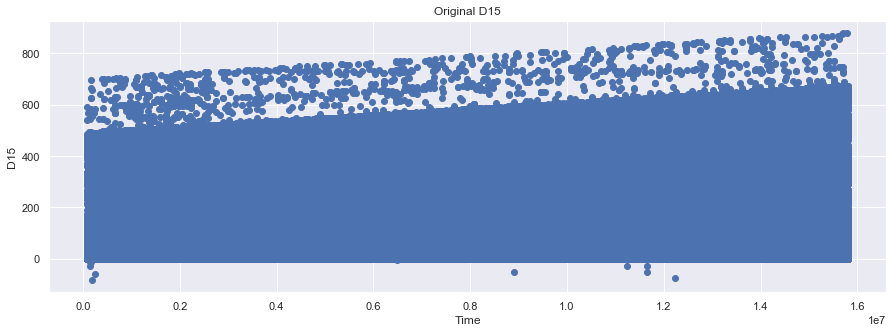

In [31]:
# PLOT ORIGINAL D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Original D15')
plt.xlabel('Time')
plt.ylabel('D15')
plt.show()

In [33]:
# NORMALIZE D COLUMNS
for i in range(1,16):
    if i in [1,2,3,5,9]: continue
    X_train['D'+str(i)] =  X_train['D'+str(i)] - X_train.TransactionDT/np.float32(24*60*60)
    X_test['D'+str(i)] = X_test['D'+str(i)] - X_test.TransactionDT/np.float32(24*60*60) 

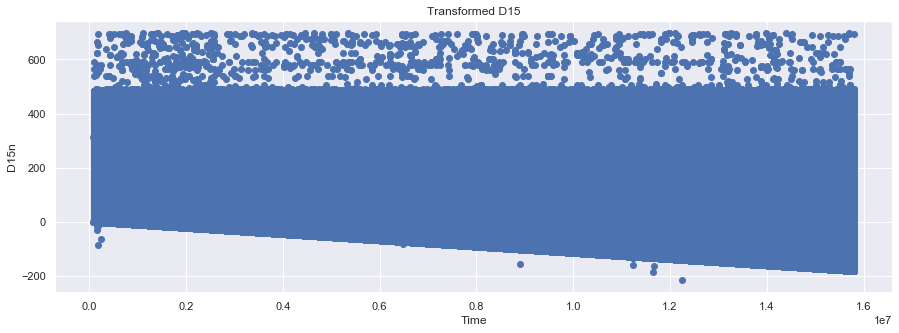

In [34]:
# PLOT TRANSFORMED D
plt.figure(figsize=(15,5))
plt.scatter(X_train.TransactionDT,X_train.D15)
plt.title('Transformed D15')
plt.xlabel('Time')
plt.ylabel('D15n')
plt.show()

In [41]:
%%time
# LABEL ENCODE AND MEMORY REDUCE
for i,f in enumerate(X_train.columns):
    # FACTORIZE CATEGORICAL VARIABLES
    if (np.str(X_train[f].dtype)=='category')|(X_train[f].dtype=='object'): 
        df_comb = pd.concat([X_train[f],X_test[f]],axis=0)
        df_comb,_ = df_comb.factorize(sort=True)
        if df_comb.max()>32000: print(f,'needs int32')
        X_train[f] = df_comb[:len(X_train)].astype('int16')
        X_test[f] = df_comb[len(X_train):].astype('int16')
    # SHIFT ALL NUMERICS POSITIVE. SET NAN to -1
    elif f not in ['TransactionAmt','TransactionDT']:
        mn = np.min((X_train[f].min(),X_test[f].min()))
        X_train[f] -= np.float32(mn)
        X_test[f] -= np.float32(mn)
        X_train[f].fillna(-1,inplace=True)
        X_test[f].fillna(-1,inplace=True)

CPU times: user 2.89 s, sys: 334 ms, total: 3.22 s
Wall time: 3.09 s


## Encoding Functions

Below are 5 encoding functions. 

(1) encode_FE does frequency encoding where it combines train and test first and then encodes. 

(2) encode_LE is a label encoded for categorical features 

(3) encode_AG makes aggregated features such as aggregated mean and std 

(4) encode_CB combines two columns 

(5) encode_AG2 makes aggregated features where it counts how many unique values of one feature is within a group. For more explanation about feature engineering, see the discussion here


In [35]:
# FREQUENCY ENCODE TOGETHER
def encode_FE(df1, df2, cols):
    for col in cols:
        df = pd.concat([df1[col],df2[col]])
        vc = df.value_counts(dropna=True, normalize=True).to_dict()
        vc[-1] = -1
        nm = col+'_FE'
        df1[nm] = df1[col].map(vc)
        df1[nm] = df1[nm].astype('float32')
        df2[nm] = df2[col].map(vc)
        df2[nm] = df2[nm].astype('float32')
        print(nm,', ',end='')
        
# LABEL ENCODE
def encode_LE(col,train=X_train,test=X_test,verbose=True):
    df_comb = pd.concat([train[col],test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    nm = col
    if df_comb.max()>32000: 
        train[nm] = df_comb[:len(train)].astype('int32')
        test[nm] = df_comb[len(train):].astype('int32')
    else:
        train[nm] = df_comb[:len(train)].astype('int16')
        test[nm] = df_comb[len(train):].astype('int16')
    del df_comb; x=gc.collect()
    if verbose: print(nm,', ',end='')
        
# GROUP AGGREGATION MEAN AND STD
# https://www.kaggle.com/kyakovlev/ieee-fe-with-some-eda
def encode_AG(main_columns, uids, aggregations=['mean'], train_df=X_train, test_df=X_test, 
              fillna=True, usena=False):
    # AGGREGATION OF MAIN WITH UID FOR GIVEN STATISTICS
    for main_column in main_columns:  
        for col in uids:
            for agg_type in aggregations:
                new_col_name = main_column+'_'+col+'_'+agg_type
                temp_df = pd.concat([train_df[[col, main_column]], test_df[[col,main_column]]])
                if usena: temp_df.loc[temp_df[main_column]==-1,main_column] = np.nan
                temp_df = temp_df.groupby([col])[main_column].agg([agg_type]).reset_index().rename(
                                                        columns={agg_type: new_col_name})

                temp_df.index = list(temp_df[col])
                temp_df = temp_df[new_col_name].to_dict()   

                train_df[new_col_name] = train_df[col].map(temp_df).astype('float32')
                test_df[new_col_name]  = test_df[col].map(temp_df).astype('float32')
                
                if fillna:
                    train_df[new_col_name].fillna(-1,inplace=True)
                    test_df[new_col_name].fillna(-1,inplace=True)
                
                print("'"+new_col_name+"'",', ',end='')
                
# COMBINE FEATURES
def encode_CB(col1,col2,df1=X_train,df2=X_test):
    nm = col1+'_'+col2
    df1[nm] = df1[col1].astype(str)+'_'+df1[col2].astype(str)
    df2[nm] = df2[col1].astype(str)+'_'+df2[col2].astype(str) 
    encode_LE(nm,verbose=False)
    print(nm,', ',end='')
    
# GROUP AGGREGATION NUNIQUE
def encode_AG2(main_columns, uids, train_df=X_train, test_df=X_test):
    for main_column in main_columns:  
        for col in uids:
            comb = pd.concat([train_df[[col]+[main_column]],test_df[[col]+[main_column]]],axis=0)
            mp = comb.groupby(col)[main_column].agg(['nunique'])['nunique'].to_dict()
            train_df[col+'_'+main_column+'_ct'] = train_df[col].map(mp).astype('float32')
            test_df[col+'_'+main_column+'_ct'] = test_df[col].map(mp).astype('float32')
            print(col+'_'+main_column+'_ct, ',end='')

## Feature Engineering

We will now engineer features. All of these features where chosen because each increases local validation. The procedure for engineering features is as follows. 
* First you think of an idea and create a new feature. 
* Then you add it to your model and evaluate whether local validation AUC increases or decreases. 
    * If AUC increases keep the feature, otherwise discard the feature.


In [36]:
%%time
# TRANSACTION AMT CENTS
X_train['cents'] = (X_train['TransactionAmt'] - np.floor(X_train['TransactionAmt'])).astype('float32')
X_test['cents'] = (X_test['TransactionAmt'] - np.floor(X_test['TransactionAmt'])).astype('float32')
print('cents, ', end='')
# FREQUENCY ENCODE: ADDR1, CARD1, CARD2, CARD3, P_EMAILDOMAIN
encode_FE(X_train,X_test,['addr1','card1','card2','card3','P_emaildomain'])
# COMBINE COLUMNS CARD1+ADDR1, CARD1+ADDR1+P_EMAILDOMAIN
encode_CB('card1','addr1')
encode_CB('card1_addr1','P_emaildomain')
# FREQUENCY ENOCDE
encode_FE(X_train,X_test,['card1_addr1','card1_addr1_P_emaildomain'])
# GROUP AGGREGATE
encode_AG(['TransactionAmt','D9','D11'],['card1','card1_addr1','card1_addr1_P_emaildomain'],['mean','std'],usena=True)

cents, addr1_FE , card1_FE , card2_FE , card3_FE , P_emaildomain_FE , card1_addr1 , card1_addr1_P_emaildomain , card1_addr1_FE , card1_addr1_P_emaildomain_FE , 'TransactionAmt_card1_mean' , 'TransactionAmt_card1_std' , 'TransactionAmt_card1_addr1_mean' , 'TransactionAmt_card1_addr1_std' , 'TransactionAmt_card1_addr1_P_emaildomain_mean' , 'TransactionAmt_card1_addr1_P_emaildomain_std' , 'D9_card1_mean' , 'D9_card1_std' , 'D9_card1_addr1_mean' , 'D9_card1_addr1_std' , 'D9_card1_addr1_P_emaildomain_mean' , 'D9_card1_addr1_P_emaildomain_std' , 'D11_card1_mean' , 'D11_card1_std' , 'D11_card1_addr1_mean' , 'D11_card1_addr1_std' , 'D11_card1_addr1_P_emaildomain_mean' , 'D11_card1_addr1_P_emaildomain_std' , CPU times: user 19.6 s, sys: 13.7 s, total: 33.3 s
Wall time: 36.2 s


## Feature Selection - Time Consistency

We added 28 new feature above. We have already removed 219 V Columns from correlation analysis done here. So we currently have 242 features now. We will now check each of our 242 for "time consistency". 

We will build 242 models. Each model will be trained on the first month of the training data and will only use one feature. 

We will then predict the last month of the training data. We want both training AUC and validation AUC to be above AUC = 0.5. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN. More techniques for feature selection are listed here


In [37]:
cols = list( X_train.columns )
cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    cols.remove(c)
    
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    cols.remove(c)


In [38]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

NOW USING THE FOLLOWING 216 FEATURES.


array(['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card5',
       'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain',
       'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
       'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
       'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M6', 'M7', 'M8',
       'M9', 'V1', 'V3', 'V4', 'V6', 'V8', 'V11', 'V13', 'V14', 'V17',
       'V20', 'V23', 'V26', 'V27', 'V30', 'V36', 'V37', 'V40', 'V41',
       'V44', 'V47', 'V48', 'V54', 'V56', 'V59', 'V62', 'V65', 'V67',
       'V68', 'V70', 'V76', 'V78', 'V80', 'V82', 'V86', 'V88', 'V89',
       'V91', 'V107', 'V108', 'V111', 'V115', 'V117', 'V120', 'V121',
       'V123', 'V124', 'V127', 'V129', 'V130', 'V136', 'V138', 'V139',
       'V142', 'V147', 'V156', 'V160', 'V162', 'V165', 'V166', 'V169',
       'V171', 'V173', 'V175', 'V176', 'V178', 'V180', 'V182', 'V185',
       'V187', 'V188', 'V198', 'V203', 'V205', 'V207', 'V209', 'V210',
       '

## Local Validation

For this competition, we used time based local validation. 

I evaluated features by training on the first 75% of the data and predicting the last 25% of the data. Konstantin had a slightly different local validaiton. He trained on the first 4 months, skipped a month, and predicted the last month. Our current XGB model with 216 features achieves AUC = 0.9363 on Chris' local validation and AUC = 0.9241 on Konstantin's local validation. Note that this is the same AUC that Konstantin's LGBM achieves without magic that he posted here and here.


In [39]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

In [43]:
import xgboost as xgb
print("XGBoost version:", xgb.__version__)

if BUILD95:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        # USE CPU
        nthread=4,
        tree_method='hist' 
        # USE GPU
#         tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)

XGBoost version: 0.90
[0]	validation_0-auc:0.825729
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.876157
[100]	validation_0-auc:0.892057
[150]	validation_0-auc:0.905567
[200]	validation_0-auc:0.917841
[250]	validation_0-auc:0.925871
[300]	validation_0-auc:0.931046
[350]	validation_0-auc:0.933771
[400]	validation_0-auc:0.935582
[450]	validation_0-auc:0.936553
[500]	validation_0-auc:0.936793
[550]	validation_0-auc:0.936809
[600]	validation_0-auc:0.936706
Stopping. Best iteration:
[538]	validation_0-auc:0.936888



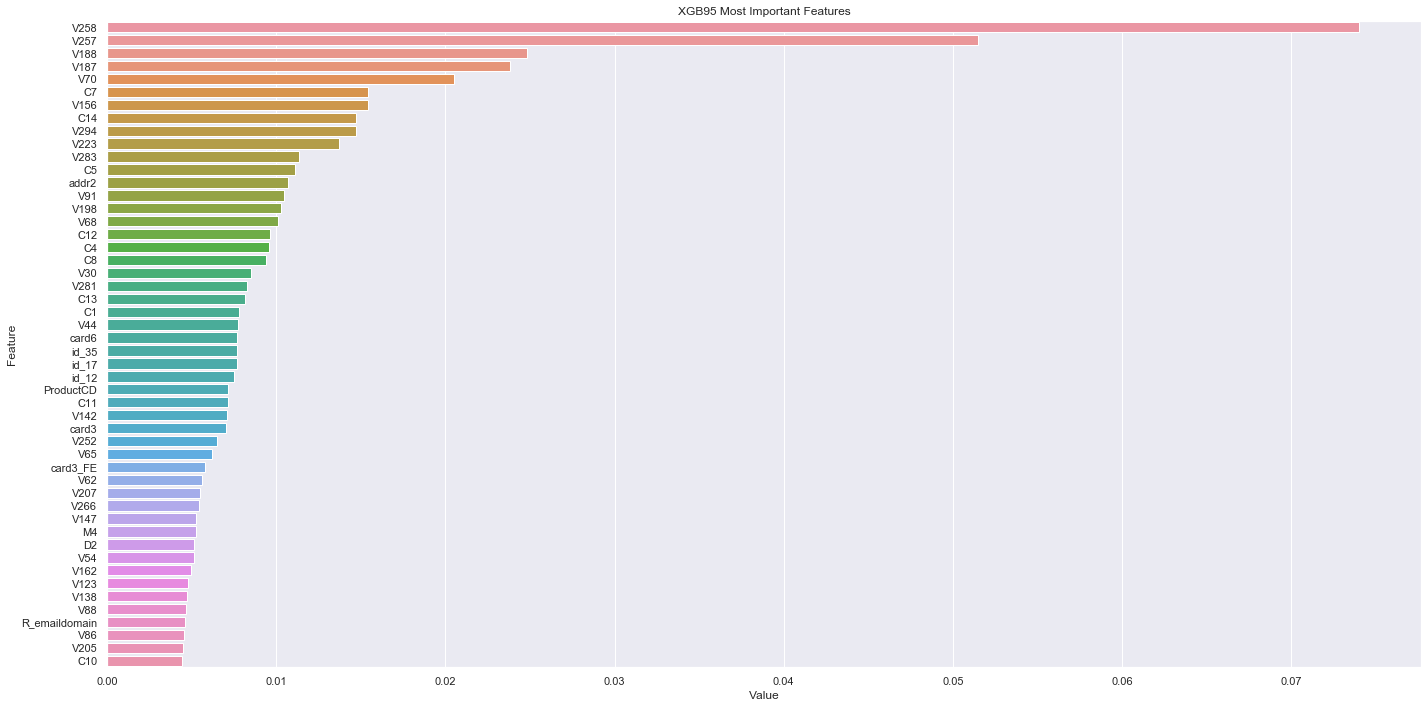

In [44]:
if BUILD95:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB95 Most Important Features')
    plt.tight_layout()
    plt.show()
    del clf, h; x=gc.collect()

## Predict test.csv

We will predict test.csv using GroupKFold with months as groups. 

The training data are the months December 2017, January 2018, February 2018, March 2018, April 2018, and May 2018. We refer to these months as 12, 13, 14, 15, 16, 17. Fold one in GroupKFold will train on months 13 thru 17 and predict month 12. Note that the only purpose of month 12 is to tell XGB when to early_stop we don't actual care about the backwards time predictions. The model trained on months 13 thru 17 will also predict test.csv which is forward in time.

Note that we use local validation to determine features but GroupKFold to predict test.csv. Many other prediction schemes were tried but GroupKFold performed best.


In [45]:
import datetime
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')
X_train['DT_M'] = X_train['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_train['DT_M'] = (X_train['DT_M'].dt.year-2017)*12 + X_train['DT_M'].dt.month 

X_test['DT_M'] = X_test['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
X_test['DT_M'] = (X_test['DT_M'].dt.year-2017)*12 + X_test['DT_M'].dt.month 


In [47]:
if BUILD95:
    oof = np.zeros(len(X_train))
    preds = np.zeros(len(X_test))

    skf = GroupKFold(n_splits=6)
    for i, (idxT, idxV) in enumerate( skf.split(X_train, y_train, groups=X_train['DT_M']) ):
        month = X_train.iloc[idxV]['DT_M'].iloc[0]
        print('Fold',i,'withholding month',month)
        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))
        clf = xgb.XGBClassifier(
            n_estimators=5000,
            max_depth=12,
            learning_rate=0.02,
            subsample=0.8,
            colsample_bytree=0.4,
            missing=-1,
            eval_metric='auc',
            # USE CPU
            nthread=4,
            tree_method='hist'
            # USE GPU
#             tree_method='gpu_hist' 
        )        
        h = clf.fit(X_train[cols].iloc[idxT], y_train.iloc[idxT], 
                eval_set=[(X_train[cols].iloc[idxV],y_train.iloc[idxV])],
                verbose=100, early_stopping_rounds=200)
    
        oof[idxV] += clf.predict_proba(X_train[cols].iloc[idxV])[:,1]
        preds += clf.predict_proba(X_test[cols])[:,1]/skf.n_splits
        del h, clf
        x=gc.collect()
    print('#'*20)
    print ('XGB95 OOF CV=',roc_auc_score(y_train,oof))

Fold 0 withholding month 12
 rows of train = 453219 rows of holdout = 137321
[0]	validation_0-auc:0.815144
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.870627
[200]	validation_0-auc:0.890719
[300]	validation_0-auc:0.901657
[400]	validation_0-auc:0.905346
[500]	validation_0-auc:0.906959
[600]	validation_0-auc:0.907462
[700]	validation_0-auc:0.90751
[800]	validation_0-auc:0.906489
Stopping. Best iteration:
[698]	validation_0-auc:0.907596

Fold 1 withholding month 15
 rows of train = 488908 rows of holdout = 101632
[0]	validation_0-auc:0.841263
Will train until validation_0-auc hasn't improved in 200 rounds.
[100]	validation_0-auc:0.90391
[200]	validation_0-auc:0.927145
[300]	validation_0-auc:0.939907
[400]	validation_0-auc:0.944753
[500]	validation_0-auc:0.945811
[600]	validation_0-auc:0.946195
[700]	validation_0-auc:0.946268
[800]	validation_0-auc:0.946283
[900]	validation_0-auc:0.946443
[1000]	validation_0-auc:0.945999
Stopping. Best iterati

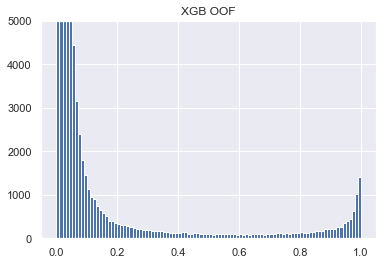

In [48]:
if BUILD95:
    plt.hist(oof,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB OOF')
    plt.show()

    X_train['oof'] = oof
    X_train.reset_index(inplace=True)
    X_train[['TransactionID','oof']].to_csv('oof_xgb_95.csv')
    X_train.set_index('TransactionID',drop=True,inplace=True)
    
else: X_train['oof'] = 0

## Kaggle Submission File XGB_95

In [51]:
preds.shape

(590540,)

In [55]:
X_test.shape

(590540, 242)

In [56]:
X_test.head()

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,...,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,cents,addr1_FE,card1_FE,card2_FE,card3_FE,P_emaildomain_FE,card1_addr1,card1_addr1_P_emaildomain,card1_addr1_FE,card1_addr1_P_emaildomain_FE,TransactionAmt_card1_mean,TransactionAmt_card1_std,TransactionAmt_card1_addr1_mean,TransactionAmt_card1_addr1_std,TransactionAmt_card1_addr1_P_emaildomain_mean,TransactionAmt_card1_addr1_P_emaildomain_std,D9_card1_mean,D9_card1_std,D9_card1_addr1_mean,D9_card1_addr1_std,D9_card1_addr1_P_emaildomain_mean,D9_card1_addr1_P_emaildomain_std,D11_card1_mean,D11_card1_std,D11_card1_addr1_mean,D11_card1_addr1_std,D11_card1_addr1_P_emaildomain_mean,D11_card1_addr1_P_emaildomain_std,DT_M
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2987000.0,86400.0,68.5,4,12926.0,-1.0,50.0,1,42.0,0,215.0,77.0,19.0,-1.0,-1,-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,-1.0,13.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,194.998596,194.999207,-1.0,-1.0,-1.0,214.672485,0,1,1,2,0,1,...,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,0.5,0.043970,0.000071,-1.000000,0.885073,-1.000000,9919.0,90211.0,0.000003,0.000000,351.316162,368.951630,141.412003,136.537903,68.015999,0.000000,1.722222,1.172132,0.000000,0.000000,0.00,0.0,94.292130,40.840729,194.985733,1.000000,194.998245,1.000000,12
2987001.0,86401.0,29.0,4,1755.0,304.0,50.0,2,2.0,0,225.0,77.0,-1.0,-1.0,12,-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,214.672470,-1.0,-1.0,-1.0,-1.0,-1.0,181.998581,-1.000000,-1.0,-1.0,-1.0,214.672470,-1,-1,-1,0,1,1,...,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.081454,0.001155,0.005230,0.885073,0.460251,23139.0,33960.0,0.000102,0.000020,233.677750,460.188324,274.933624,607.229187,770.199829,1184.171387,1.614285,1.301857,1.305555,1.344265,1.75,1.0,223.102081,188.755646,172.104980,107.730957,146.431976,90.570015,12
2987002.0,86469.0,59.0,4,3663.0,390.0,50.0,3,66.0,1,230.0,77.0,287.0,-1.0,23,-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,214.671692,-1.0,-1.0,-1.0,-1.0,-1.0,181.997803,496.998413,-1.0,-1.0,-1.0,529.671692,0,1,1,0,0,0,...,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.050084,0.001875,0.065561,0.885073,0.010208,27253.0,44328.0,0.000056,0.000005,96.400543,100.106255,51.845528,21.890776,73.015999,15.793308,1.736111,1.021517,0.000000,0.000000,0.00,0.0,166.001282,136.181152,231.584045,158.628296,497.104919,1.182887,12
2987003.0,86499.0,50.0,4,17132.0,467.0,50.0,2,17.0,1,376.0,77.0,-1.0,-1.0,31,-1,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,308.671326,0.0,-1.0,-1.0,-1.0,-1.0,265.997437,-1.000000,-1.0,-1.0,-1.0,325.671326,-1,-1,-1,0,1,0,...,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1.0,-1,-1,-1,-1,-1,-1,-1,-1,0.0,0.018057,0.007126,0.010528,0.885073,0.203397,20223.0,26051.0,0.000434,0.000222,122.801338,192.705978,124.181534,248.269394,76.057663,58.292759,1.564967,1.317801,1.847222,1.093788,1.75,1.0,242.123764,195.350113,273.574188,178.209549,228.508179,128.155441,12
2987004.0,86506.0,50.0,1,3497.0,414.0,50.0,2,2.0,0,320.0,77.0,-1.0,-1.0,12,-1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.0,-1.0,-1.0,-1.000000,-1,-1,-1,-1,-1,-1,...,44.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0,-1,1,1,7,70,32.0,51,2,1,0,1,1,1,282,0.0,0.006821,0.000029,0.024977,0.885073,0.460251,26908.0,43561.0,0.000000,0.000000,96.357224,55.814594,49.411999,0.000000,49.515999,0.000000,1.666666,1.098601,0.000000,0.000000,0.00,0.0,252.365021,209.043777,181.9

In [52]:
sample_submission.shape

(506691, 2)

In [53]:
args.DATA_DIR

'../../data/contest/ieee-fraud-detection/'

In [54]:
sample_submission.head()

,TransactionID,isFraud
0,3663549,0.5
1,3663550,0.5
2,3663551,0.5
3,3663552,0.5
4,3663553,0.5


In [57]:
X_test['isFraud'] = preds

In [58]:
subs = X_test.reset_index()[['TransactionID', 'isFraud']]

In [60]:
subs['TransactionID'] = subs['TransactionID'].map(int)

In [61]:
subs.head()

,TransactionID,isFraud
0,2987000,0.028004
1,2987001,0.008284
2,2987002,0.005441
3,2987003,0.001528
4,2987004,0.001680


In [62]:
subs.to_csv(os.path.join(args.DATA_DIR, 'sub_xgb_95.csv'),index=False)

In [49]:
if BUILD95:
    sample_submission = pd.read_csv(os.path.join(args.DATA_DIR, 'sample_submission.csv'))
    sample_submission.isFraud = preds
    sample_submission.to_csv(os.path.join(args.DATA_DIR, 'sub_xgb_95.csv'),index=False)

    plt.hist(sample_submission.isFraud,bins=100)
    plt.ylim((0,5000))
    plt.title('XGB95 Submission')
    plt.show()


ValueError: Length of values does not match length of index

## The Magic Feature - UID

We will now create and use the MAGIC FEATURES. First we create a UID which will help our model find clients (credit cards). This UID isn't perfect. Many UID values contain 2 or more clients inside. However our model will detect this and by adding more splits with its trees, it will split these UIDs and find the single clients (credit cards).


In [ ]:
X_train['day'] = X_train.TransactionDT / (24*60*60)
X_train['uid'] = X_train.card1_addr1.astype(str)+'_'+np.floor(X_train.day-X_train.D1).astype(str)

X_test['day'] = X_test.TransactionDT / (24*60*60)
X_test['uid'] = X_test.card1_addr1.astype(str)+'_'+np.floor(X_test.day-X_test.D1).astype(str)


## Group Aggregation Features

For our model to use the new UID, we need to make lots of aggregated group features. We will add 47 new features! The pictures in the introduction to this notebook explain why this works. Note that after aggregation, we remove UID from our model. We don't use UID directly.


In [ ]:
%%time
# FREQUENCY ENCODE UID
encode_FE(X_train,X_test,['uid'])
# AGGREGATE 
encode_AG(['TransactionAmt','D4','D9','D10','D15'],['uid'],['mean','std'],fillna=True,usena=True)
# AGGREGATE
encode_AG(['C'+str(x) for x in range(1,15) if x!=3],['uid'],['mean'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE
encode_AG(['M'+str(x) for x in range(1,10)],['uid'],['mean'],fillna=True,usena=True)
# AGGREGATE
encode_AG2(['P_emaildomain','dist1','DT_M','id_02','cents'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREGATE
encode_AG(['C14'],['uid'],['std'],X_train,X_test,fillna=True,usena=True)
# AGGREGATE 
encode_AG2(['C13','V314'], ['uid'], train_df=X_train, test_df=X_test)
# AGGREATE 
encode_AG2(['V127','V136','V309','V307','V320'], ['uid'], train_df=X_train, test_df=X_test)
# NEW FEATURE
X_train['outsider15'] = (np.abs(X_train.D1-X_train.D15)>3).astype('int8')
X_test['outsider15'] = (np.abs(X_test.D1-X_test.D15)>3).astype('int8')
print('outsider15')

In [ ]:
print('NOW USING THE FOLLOWING',len(cols),'FEATURES.')
np.array(cols)

## Local Validation

We will now perform local validation with the new magic features included. Chris' local validation now achieves AUC = 0.9472 and Konstantin's local validation achieves AUC = 0.9343. Note that without the magic features we achieved AUC = 0.9363 and AUC = 0.9241. We gained AUC 0.01 in both validations therefore our LB should increase from 0.95 to 0.96. Konstantin's LGBM with magic scores Konstantin local validation AUC = 0.9377 here


In [ ]:
# CHRIS - TRAIN 75% PREDICT 25%
idxT = X_train.index[:3*len(X_train)//4]
idxV = X_train.index[3*len(X_train)//4:]

# KONSTANTIN - TRAIN 4 SKIP 1 PREDICT 1 MONTH
#idxT = X_train.index[:417559]
#idxV = X_train.index[-89326:]

if BUILD96:
    clf = xgb.XGBClassifier( 
        n_estimators=2000,
        max_depth=12, 
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        missing=-1, 
        eval_metric='auc',
        nthread=4,
        tree_method='hist' 
#         tree_method='gpu_hist' 
    )
    h = clf.fit(X_train.loc[idxT,cols], y_train[idxT], 
        eval_set=[(X_train.loc[idxV,cols],y_train[idxV])],
        verbose=50, early_stopping_rounds=100)



In [4]:
if BUILD96:

    feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])

    plt.figure(figsize=(20, 10))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
    plt.title('XGB96 Most Important')
    plt.tight_layout()
    plt.show()
        
    del clf, h; x=gc.collect()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
